<a href="https://colab.research.google.com/github/AprajitaChhawi/A-case-study-on-credit-default/blob/main/Copy_of_maxlife_case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
credit_df = pd.read_excel (r'case_study_data.xlsx')
credit_df

,checkin_acc,duration,credit_history,purpose,amount,svaing_acc,present_emp_since,inst_rate,personal_status,other_debtors,residing_since,property,age,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker,status
0,A11,9,A34,A43,1754,A65,A75,6,A93,A101,6,A121,101,A143,A152,3,A173,2,A192,A201,1
1,A12,72,A32,A43,8927,A61,A73,3,A92,A101,3,A121,33,A143,A152,2,A173,2,A191,A201,2
2,A14,18,A34,A46,3144,A61,A74,3,A93,A101,5,A121,74,A143,A152,2,A172,3,A191,A201,1
3,A11,63,A32,A42,11823,A61,A74,3,A93,A103,6,A122,68,A143,A153,2,A173,3,A191,A201,1
4,A11,36,A33,A40,7305,A61,A73,5,A93,A101,6,A124,80,A143,A153,3,A173,3,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,18,A32,A42,2604,A61,A74,5,A92,A101,6,A121,47,A143,A152,2,A172,2,A191,A201,1
996,A11,45,A32,A41,5786,A61,A73,6,A91,A101,6,A122,60,A143,A152,2,A174,2,A192,A201,1
997,A14,18,A32,A43,1206,A61,A75,6,A93,A101,6,A123,57,A143,A152,2,A173,2,A191,A201,1
998,A11,68,A32,A43,2768,A61,A73,6,A93,A101,6,A124,35,A143,A153,2,A173,2,A192,A201,2


In [ ]:
def preprocess_data():
    credit_df_one_hot = credit_df.copy() #SAVE A COPY FOR LATER 
    for column in credit_df.select_dtypes(include='object').columns: # Remove 'A' from categorical columns
        credit_df[column] = credit_df[column].str.replace('A','')
        credit_df_one_hot.drop([column], axis=1, inplace=True)
    # THERE ARE MANY CATEGORICAL COLUMNS    
    # One hot encode Categorical columns
    credit_df_one_hot = pd.concat([pd.get_dummies(credit_df.select_dtypes(include='object'), drop_first=True), credit_df_one_hot], axis=1) 
    return credit_df, credit_df_one_hot

In [ ]:
from sklearn.preprocessing import LabelEncoder 
credit_df, dummy_df = preprocess_data()
encode = LabelEncoder() #Encode target labels with value between 0 and n_classes-1
encoded = encode.fit_transform(credit_df['status']) #Fit label encoder and return encoded labels
credit_df['status'] = encoded
dummy_df['status'] = encoded

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
rf = RandomForestClassifier()
params = {'max_depth' : [1,2,3,4,5,6],'min_samples_leaf' : [0.01,0.02,0.04,0.06],'max_features' : [0.1,0.2,0.4,0.8],'n_estimators' : [100,150,200,250,300]}
rf_cv = RandomizedSearchCV(estimator=rf,param_distributions=params,n_iter=100,cv=10,scoring='accuracy',n_jobs=-1,verbose=3)
X = credit_df.drop(['status','age'], axis=1)
y = credit_df['status']
rf_cv.fit(X, y) # Training
rf_best = rf_cv.best_estimator_ #Best Estimator

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.9min finished


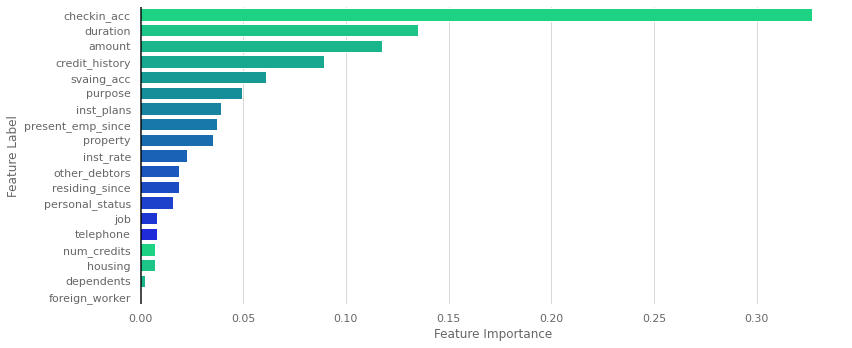

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
selected_features = X.columns.to_list()
feature_importance = pd.DataFrame(selected_features, columns = ["Feature Label"])
feature_importance["Feature Importance"] = rf_best.feature_importances_
feature_importance = feature_importance.sort_values(by="Feature Importance", ascending=False) # Sort by feature importance
sns.set(font_scale = 1) # Set graph style
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})
f, ax = plt.subplots(figsize=(12, 5)) 
sns.barplot(x = "Feature Importance", y = "Feature Label",
            palette = reversed(sns.color_palette('winter', 15)),  data = feature_importance)
ax.axvline(x = 0, color = 'black', linewidth = 4, alpha = .7) # Generate a bolded horizontal line at y = 0
ax.set_frame_on(False) # Turn frame off
plt.tight_layout() # Tight layout
plt.savefig("feature_importance.png", dpi = 1080)
plt.show()

In [ ]:
!pip install eli5
import eli5 
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf_best, random_state=105).fit(X, y)
eli5.show_weights(perm, feature_names = X.columns.to_list()) #showimg the weights of all the feature

     |████████████████████████████████| 112kB 5.3MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0856 ± 0.0115,checkin_acc
0.0662 ± 0.0145,duration
0.0416 ± 0.0081,credit_history
0.0416 ± 0.0154,amount
0.0296 ± 0.0069,svaing_acc
0.0142 ± 0.0066,property
0.0112 ± 0.0039,purpose
0.0096 ± 0.0020,personal_status
0.0060 ± 0.0036,present_emp_since
0.0058 ± 0.0074,residing_since


In [ ]:
dummy_df.head()

,checkin_acc_12,checkin_acc_13,checkin_acc_14,credit_history_31,credit_history_32,credit_history_33,credit_history_34,purpose_41,purpose_410,purpose_42,purpose_43,purpose_44,purpose_45,purpose_46,purpose_48,purpose_49,svaing_acc_62,svaing_acc_63,svaing_acc_64,svaing_acc_65,present_emp_since_72,present_emp_since_73,present_emp_since_74,present_emp_since_75,personal_status_92,personal_status_93,personal_status_94,other_debtors_102,other_debtors_103,property_122,property_123,property_124,inst_plans_142,inst_plans_143,housing_152,housing_153,job_172,job_173,job_174,telephone_192,foreign_worker_202,duration,amount,inst_rate,residing_since,age,num_credits,dependents,status
0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,9,1754,6,6,101,3,2,0
1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,72,8927,3,3,33,2,2,1
2,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,18,3144,3,5,74,2,3,0
3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,63,11823,3,6,68,2,3,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,36,7305,5,6,80,3,3,1


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(f2_measure)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
import numpy as np
X = dummy_df.drop('status', axis=1)
y = dummy_df['status']
model = DummyClassifier(strategy='constant', constant=1)
scores = evaluate_model(X, y, model)
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean F2: 0.682 (0.000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
def get_models():
    models, names = list(), list()
    # LR 
    models.append(LogisticRegression(solver='liblinear')) 
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis()) 
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # GPC
    models.append(GaussianProcessClassifier()) 
    names.append('GPC')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    return models, names

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
models, names = get_models()
results = list()
for i in range(len(models)):
    pipeline = Pipeline(steps=[('MinMax',MinMaxScaler()),('m',models[i])])
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>LR 0.495 (0.075)
>LDA 0.511 (0.074)
>NB 0.612 (0.056)
>GPC 0.195 (0.083)
>SVM 0.416 (0.071)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
powert = PowerTransformer()
scaler = MinMaxScaler()
under_sample = RepeatedEditedNearestNeighbours()
X_scale = scaler.fit_transform(X) #X_t = powert.fit_transform(X_scale)
X_s, y_s = under_sample.fit_resample(X_scale, y)
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.1, stratify=y_s, random_state=1)
model = LogisticRegression(solver='liblinear', class_weight='balanced')
c_values = [10000, 1000, 800, 500, 100, 10, 1.0, 0.1, 0.01, 0.001]
grid = dict(C=c_values)
metric = make_scorer(f2_measure)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring=metric,error_score=0)
grid_result = grid_search.fit(X_s, y_s)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Best: 0.849099 using {'C': 10}


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[22  3]
 [ 2 28]]
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        25
           1       0.90      0.93      0.92        30

    accuracy                           0.91        55
   macro avg       0.91      0.91      0.91        55
weighted avg       0.91      0.91      0.91        55



In [ ]:
from sklearn.metrics import roc_curve
y_pred_proba = best_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans) # locate the index of the largest g-mean
print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.657062, G-mean=0.927


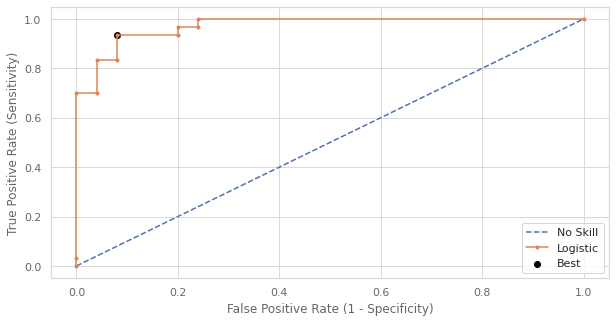

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([0,1], [0,1], linestyle='--', label='No Skill') 
plt.plot(fpr, tpr, marker='.', label='Logistic') 
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
plt.xlabel('False Positive Rate (1 - Specificity)') # axis labels
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.657062, F-score=0.933


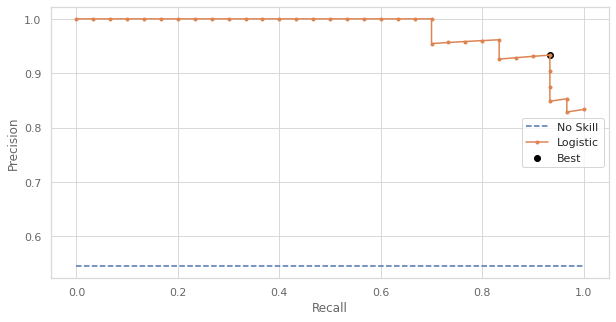

In [ ]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.figure(figsize=(10,5))
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
plt.plot(recall, precision, marker='.', label='Logistic') 
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
class_names = ['-VE','+VE']

Normalized confusion matrix
[[0.88 0.12]
 [0.07 0.93]]


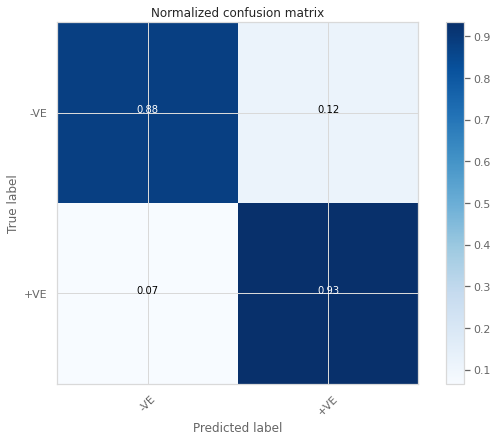

In [ ]:
%matplotlib inline
np.set_printoptions(precision=2)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')